In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns

# Data Generation

In [2]:
sns.set_style(
    style='darkgrid',
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

# Kaggle Data
- https://www.kaggle.com/datasets/shenba/time-series-datasets?resource=download

In [3]:
prod_df = pd.read_csv('Electric_Production.csv')


In [4]:
prod_df.head()

,DATE,IPG2211A2N
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151


In [5]:
prod_df.tail()

,DATE,IPG2211A2N
392,9/1/2017,98.6154
393,10/1/2017,93.6137
394,11/1/2017,97.3359
395,12/1/2017,114.7212
396,1/1/2018,129.4048


In [6]:
prod_df = prod_df.dropna()

In [7]:
prod_df.columns = ["Date", "Production"]

In [8]:
prod_df.head()

,Date,Production
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151


In [9]:
prod_df["Date"] = pd.to_datetime(prod_df["Date"])

In [10]:
prod_df.head()

,Date,Production
0,1985-01-01,72.5052
1,1985-02-01,70.6720
2,1985-03-01,62.4502
3,1985-04-01,57.4714
4,1985-05-01,55.3151


In [11]:
prod_df.set_index('Date',inplace=True)

In [12]:
prod_df.head()

,Production
Date,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


In [13]:
prod_df.describe()

,Production
count,397.000000
mean,88.847218
std,15.387834
min,55.315100
25%,77.105200
50%,89.779500
75%,100.524400
max,129.404800


[Text(0.5, 1.0, 'Kaggle Electric Production Data'),
 Text(0.5, 0, 'years'),
 Text(0, 0.5, '')]

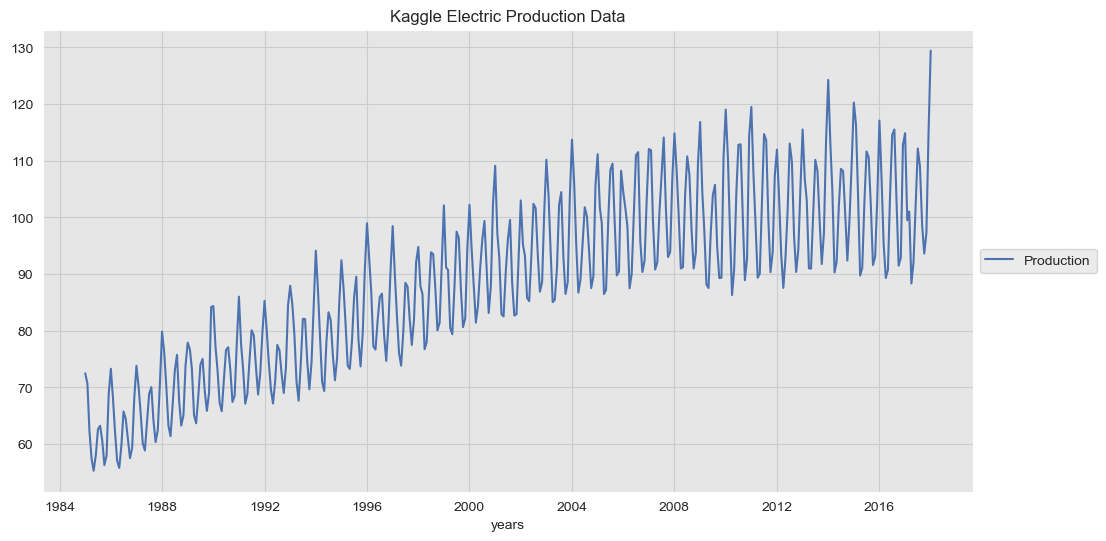

In [14]:
fig, ax = plt.subplots()
sns.lineplot(x='Date', y='Production', data=prod_df, color=sns_c[0], label='Production', ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Kaggle Electric Production Data', xlabel='years', ylabel='')

# Preprocessing

- Seasonal Decomposing

In [15]:
df = prod_df.copy() 

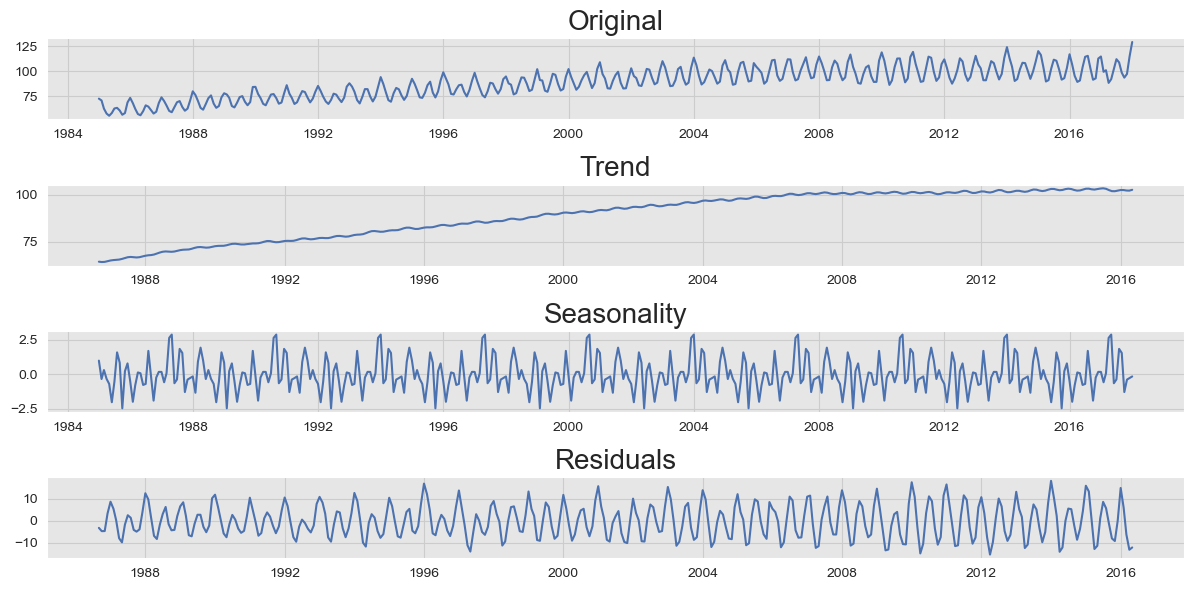

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose

def seasonal_decompose_analysis(timeseries, model, periods):
    decomposition = seasonal_decompose(timeseries, model = model, period = periods)

    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    plt.subplot(411)
    plt.title('Original', fontsize=20)
    plt.plot(timeseries, label='Original')
    plt.subplot(412)
    plt.title('Trend', fontsize=20)
    plt.plot(trend, label='Trend')
    plt.subplot(413)
    plt.title('Seasonality', fontsize=20)
    plt.plot(seasonal,label='Seasonality')
    plt.subplot(414)
    plt.title('Residuals', fontsize=20)
    plt.plot(residual, label='Residuals')
    plt.tight_layout()

seasonal_decompose_analysis(df['Production'], 'additive', 40)

We observe a seasonality of around 1 year or 12 months

- Check Stationarity

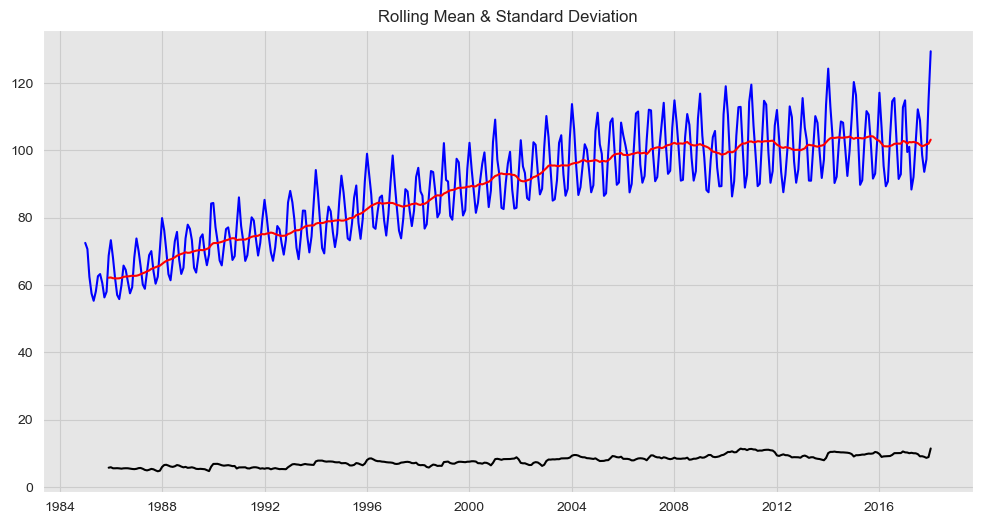

Results of Dickey-Fuller Test
Test Statistic                  -2.256990
p-value                          0.186215
#Lags Used                      15.000000
Number of Observations Used    381.000000
Critical Value (1%)             -3.447631
Critical Value (5%)             -2.869156
Critical Value (10%)            -2.570827
dtype: float64


In [17]:
from statsmodels.tsa.stattools import adfuller

def stationarity_test(timeseries, rolling_window):
    rolling_mean = timeseries.rolling(window=rolling_window).mean()
    rolling_std = timeseries.rolling(window=rolling_window).std()

    orig = plt.plot(timeseries, color='blue', label= 'Original')
    mean = plt.plot(rolling_mean, color='red', label= 'Rolling Mean')
    std = plt.plot(rolling_std, color='black', label = 'Rolling Std')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    # Dickey-Fuller test
    print('Results of Dickey-Fuller Test')
    test = adfuller(timeseries, autolag='AIC')
    output = pd.Series(test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
        output['Critical Value (%s)'%key] = value
    print(output)
    
stationarity_test(timeseries = df['Production'], rolling_window = 12)

- p-value is greater than 0 (usually want it to be less than 0.05) => non-stationary
- remove stationarity

- perform seasonal first difference

In [18]:
df['Seasonal First Difference'] = df['Production'] - df['Production'].shift(12)

- perform dickey fuller test

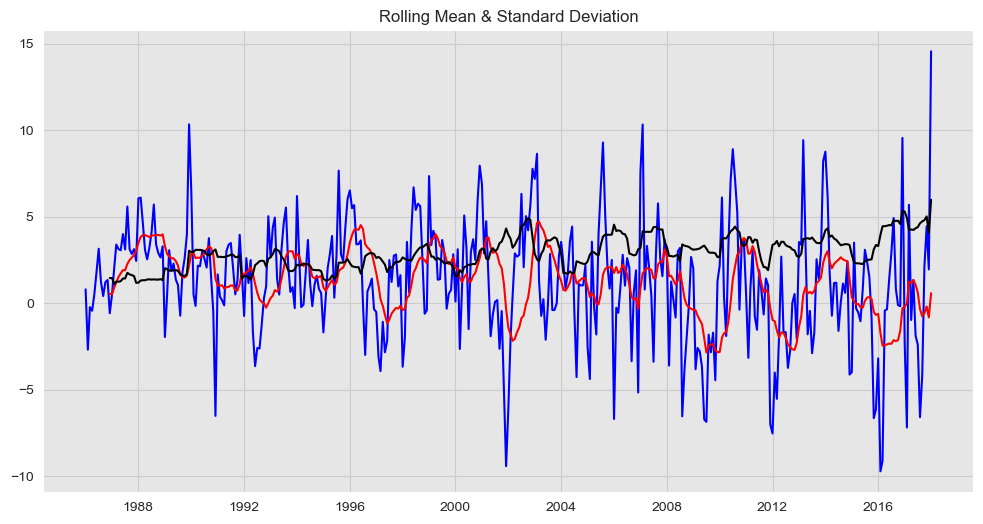

Results of Dickey-Fuller Test
Test Statistic                -5.673482e+00
p-value                        8.812645e-07
#Lags Used                     1.200000e+01
Number of Observations Used    3.720000e+02
Critical Value (1%)           -3.448052e+00
Critical Value (5%)           -2.869341e+00
Critical Value (10%)          -2.570926e+00
dtype: float64


In [19]:
stationarity_test(df['Seasonal First Difference'].dropna(),12)

- perform acf and pacf to determine parameters of SARIMAX

In [20]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

c:\Users\Abhinav\anaconda3\envs\timeSeries\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


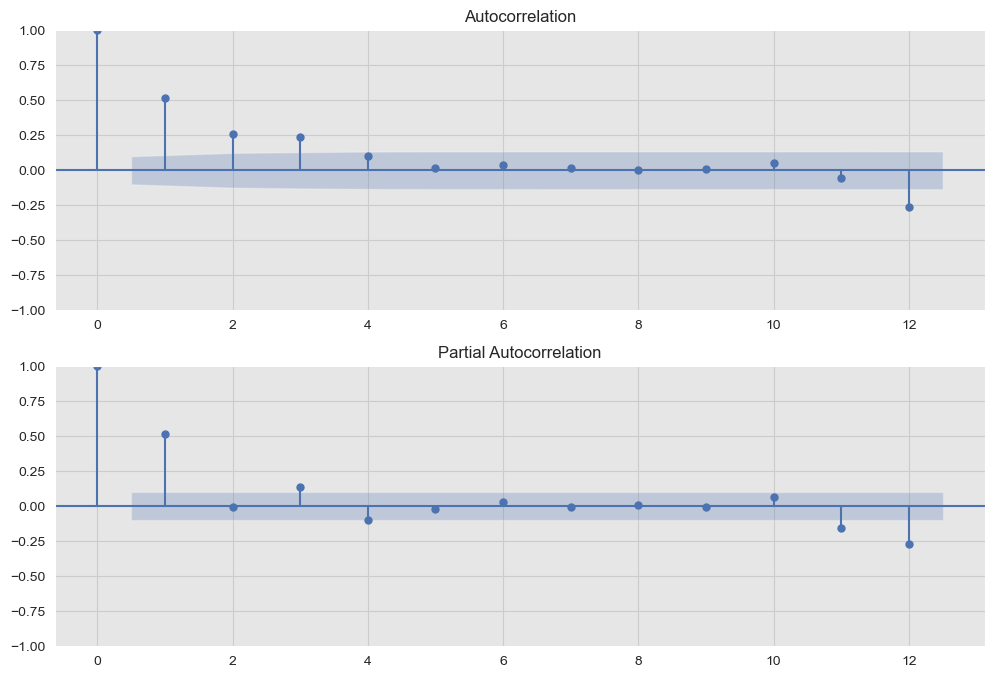

In [21]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df['Seasonal First Difference'].iloc[12:],lags=12,ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df['Seasonal First Difference'].iloc[12:],lags=12,ax=ax2)

- autocorrelation graph tells us the AR lag p = 4
- partial autocorrelation graph tells us the MA lag q = 2
- we consider first order seasonal difference d = 1

- first we show that ARIMA does not work as data is seasonal

In [22]:
from statsmodels.tsa.arima.model import ARIMA
model=ARIMA(df['Production'],order=(4,1,2))
model_fit=model.fit()
model_fit.summary()

c:\Users\Abhinav\anaconda3\envs\timeSeries\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Abhinav\anaconda3\envs\timeSeries\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Abhinav\anaconda3\envs\timeSeries\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Abhinav\anaconda3\envs\timeSeries\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Production   No. Observations:                  397
Model:                 ARIMA(4, 1, 2)   Log Likelihood               -1038.154
Date:                Tue, 04 Apr 2023   AIC                           2090.308
Time:                        15:07:28   BIC                           2118.178
Sample:                    01-01-1985   HQIC                          2101.349
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7838      0.051     15.475      0.000       0.685       0.883
ar.L2         -0.9694      0.056    -17.365      0.000      -1.079      -0.860
ar.L3         -0.0305      0.056     -0.546      0.585      -0.140       0.079
ar.L4         -0.1850      0.050     -3.725      0.000      -0.282      -0.088
ma.L1         -0.9844      0.037    -26.491      0.000      -1.057      -0.912
ma.L2          0.9437      0.026     36.186      0.000       0.893       0.995
sigma2        10.9281      0.759     14.400      0.000       9.441      12.416
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 9.42
Prob(Q):                              0.99   Prob(JB):                         0.01
Heteroskedasticity (H):               1.90   Skew:                             0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<Axes: xlabel='Date'>

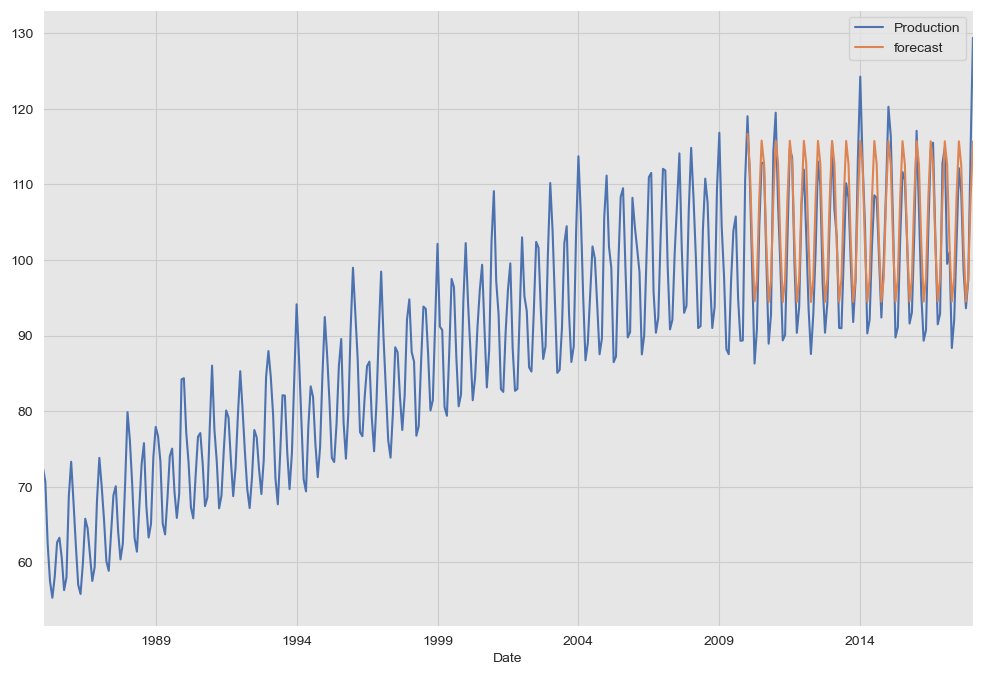

In [23]:
df['forecast']=model_fit.predict(start=300,end=397,dynamic=True)
df[['Production','forecast']].plot(figsize=(12,8))

### next we use SARIMAX

In [24]:
n = 397
prop_train = 0.95
n_train = round(prop_train * n)
sarimax_train = df['Production'][:n_train]
sarimax_test = df['Production'][n_train:]

In [25]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model=SARIMAX(sarimax_train,order=(2, 1, 1),seasonal_order=(2,1,1,12))
results=model.fit()
results.summary()

c:\Users\Abhinav\anaconda3\envs\timeSeries\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Abhinav\anaconda3\envs\timeSeries\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         Production   No. Observations:                  377
Model:             SARIMAX(2, 1, 1)x(2, 1, 1, 12)   Log Likelihood                -816.401
Date:                            Tue, 04 Apr 2023   AIC                           1646.803
Time:                                    15:07:31   BIC                           1674.083
Sample:                                01-01-1985   HQIC                          1657.645
                                     - 05-01-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5466      0.056      9.824      0.000       0.438       0.656
ar.L2         -0.0727      0.052     -1.389      0.165      -0.175       0.030
ma.L1         -0.9434      0.022    -41.984      0.000      -0.987      -0.899
ar.S.L12      -0.0133      0.081     -0.165      0.869      -0.172       0.145
ar.S.L24      -0.2031      0.066     -3.062      0.002      -0.333      -0.073
ma.S.L12      -0.6599      0.074     -8.954      0.000      -0.804      -0.515
sigma2         5.0227      0.334     15.025      0.000       4.368       5.678
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                16.22
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               2.45   Skew:                            -0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [26]:
std_sarimax = np.sqrt(np.sum(np.power(results.bse, 2)))
df['forecast'] = results.predict(start=n_train,end=n,dynamic=True)
df['std'] = std_sarimax
df['forecast_lwr'] = df['forecast'] - 2*df['std']
df['forecast_upr'] = df['forecast'] + 2*df['std']

In [27]:
temp = prod_df.copy()
temp = temp.reset_index()

[Text(0.5, 1.0, 'Kaggle Real Data'), Text(0.5, 0, 'Date'), Text(0, 0.5, '')]

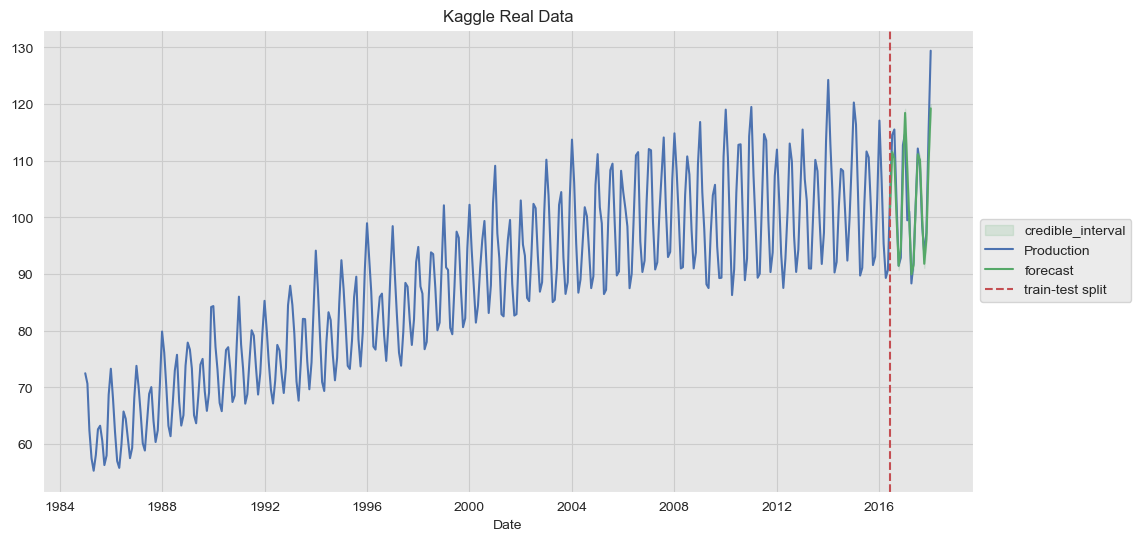

In [28]:
fig, ax = plt.subplots()

ax.fill_between(
    x=temp['Date'], 
    y1=df['forecast_lwr'], 
    y2=df['forecast_upr'], 
    color=sns_c[2], 
    alpha=0.15, 
    label='credible_interval'
)

sns.lineplot(x='Date', y='Production', data=df, color=sns_c[0], label = 'Production', ax=ax)
sns.lineplot(x='Date', y='forecast', data=df, color=sns_c[2], label='forecast', ax=ax)

ax.axvline(temp['Date'][n_train], color=sns_c[3], linestyle='--', label='train-test split')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Kaggle Real Data', xlabel='Date', ylabel='')

In [29]:
sarimax_pred = df['forecast'][n_train:].to_numpy().reshape((n-n_train,1))
sarimax_test = sarimax_test.to_numpy().reshape((sarimax_test.shape[0],1))

In [30]:
from sklearn.metrics import r2_score
sarimax_R2_score = r2_score(sarimax_test, sarimax_pred)
print(f'R2 Score Test = {sarimax_R2_score}')

R2 Score Test = 0.8557514585376645


In [31]:
from sklearn.metrics import mean_absolute_error
sarimax_MAE = mean_absolute_error(y_true=sarimax_test, y_pred=sarimax_pred)
print(f'MAE Test = {sarimax_MAE}')

MAE Test = 2.8808591099678


c:\Users\Abhinav\anaconda3\envs\timeSeries\Lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 1.0, 'Sarimax Model - Errors'),
 Text(0.5, 0, 'error'),
 Text(0, 0.5, '')]

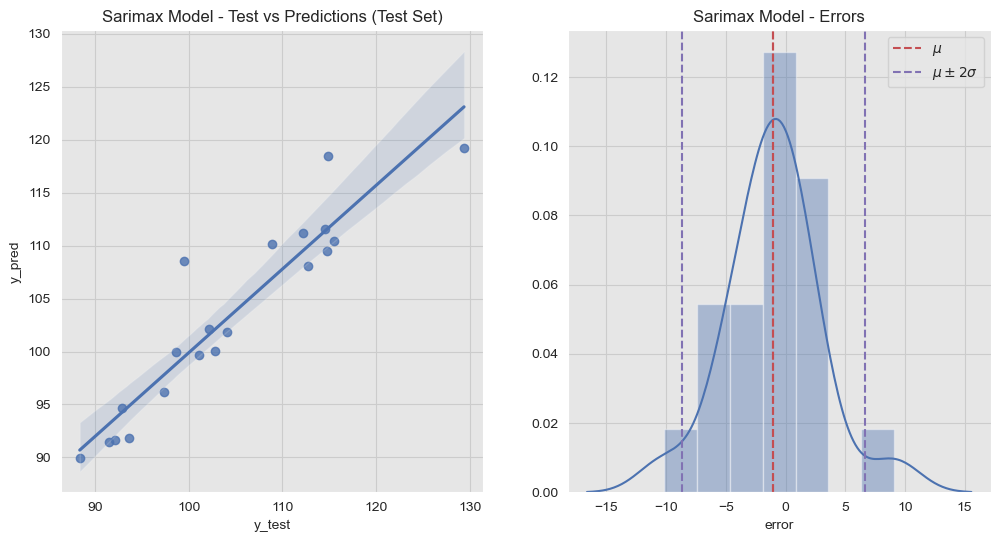

In [32]:
errors = sarimax_pred - sarimax_test
errors = errors.flatten()
errors_mean = errors.mean()
errors_std = errors.std()

fig, ax = plt.subplots(1, 2, figsize=(12, 6)) 
sns.regplot(x=sarimax_test.flatten(), y=sarimax_pred.flatten(), ax=ax[0])
sns.distplot(a=errors, ax=ax[1])
ax[1].axvline(x=errors_mean, color=sns_c[3], linestyle='--', label=f'$\mu$')
ax[1].axvline(x=errors_mean + 2*errors_std, color=sns_c[4], linestyle='--', label=f'$\mu \pm 2\sigma$')
ax[1].axvline(x=errors_mean - 2*errors_std, color=sns_c[4], linestyle='--')
ax[1].axvline(x=errors_mean, color=sns_c[3], linestyle='--')
ax[1].legend()
ax[0].set(title='Sarimax Model - Test vs Predictions (Test Set)', xlabel='y_test', ylabel='y_pred');
ax[1].set(title='Sarimax Model - Errors', xlabel='error', ylabel=None)

- future prediction

In [33]:
from pandas.tseries.offsets import DateOffset
future_dates=[df.index[-1]+ DateOffset(months=x)for x in range(0,60)]

In [34]:
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=df.columns)

In [35]:
future_datest_df.index.name = "Date"

In [36]:
future_datest_df.tail()

,Production,Seasonal First Difference,forecast,std,forecast_lwr,forecast_upr
Date,,,,,,
2022-08-01,NaN,NaN,NaN,NaN,NaN,NaN
2022-09-01,NaN,NaN,NaN,NaN,NaN,NaN
2022-10-01,NaN,NaN,NaN,NaN,NaN,NaN
2022-11-01,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-01,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
new_df=pd.concat([df,future_datest_df])

In [38]:
std_sarimax = np.sqrt(np.sum(np.power(results.bse, 2)))
new_df['forecast'] = results.predict(start=n_train,end=new_df.shape[0],dynamic=True)
new_df['std'] = std_sarimax
new_df['forecast_lwr'] = new_df['forecast'] - 2*new_df['std']
new_df['forecast_upr'] = new_df['forecast'] + 2*new_df['std']

In [39]:
temp2 = new_df.copy()
temp2 = temp2.reset_index()

[Text(0.5, 1.0, 'Kaggle Real Data'), Text(0.5, 0, 'Date'), Text(0, 0.5, '')]

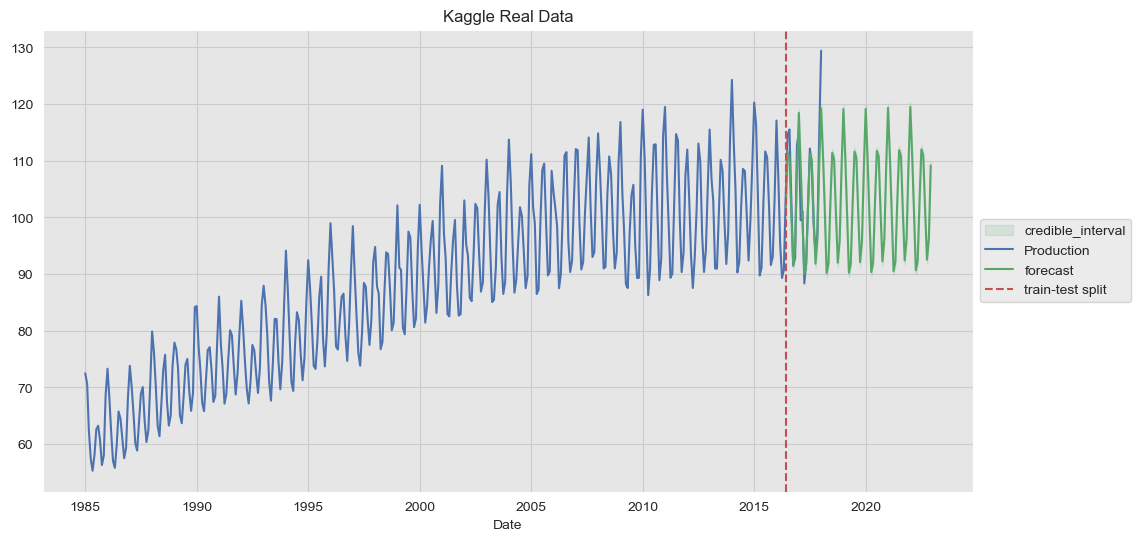

In [40]:
fig, ax = plt.subplots()

ax.fill_between(
    x=temp2['Date'], 
    y1=new_df['forecast_lwr'], 
    y2=new_df['forecast_upr'], 
    color=sns_c[2], 
    alpha=0.15, 
    label='credible_interval'
)

sns.lineplot(x='Date', y='Production', data=new_df, color=sns_c[0], label = 'Production', ax=ax)
sns.lineplot(x='Date', y='forecast', data=new_df, color=sns_c[2], label='forecast', ax=ax)

ax.axvline(temp2['Date'][n_train], color=sns_c[3], linestyle='--', label='train-test split')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Kaggle Real Data', xlabel='Date', ylabel='')

## Gaussian Processes for Time-Series Forecasting 
### (A non-parametric model)


### Deciding kernels for the components of the data is the main part

In [48]:
from sklearn.gaussian_process.kernels import RationalQuadratic, RBF
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared, ConstantKernel

# To model noise, noise_level = sigma**2
k0 = WhiteKernel(noise_level=0.3**2, noise_level_bounds=(0.1**2, 0.5**2))

# To model periodic component, periodicity to be set as what is observed in data
k1 = ConstantKernel(constant_value=2) * \
  ExpSineSquared(length_scale=1.0, periodicity=12, periodicity_bounds=(8, 14))

# To model the trend component
k2 = ConstantKernel(constant_value=10000, constant_value_bounds=(1e-2, 1e6)) * \
  RBF(length_scale=10.0, length_scale_bounds=(1e-2, 1e4)) 

# To model the trend (non linear), its a scale mixture of RBF kernels
# k2 = ConstantKernel(constant_value=100, constant_value_bounds=(1, 500)) * \
#   RationalQuadratic(length_scale=500, length_scale_bounds=(1, 1e4), alpha= 50.0, alpha_bounds=(1, 1e3))

# To model another seasonal component
k3 = ConstantKernel(constant_value=1) * \
  ExpSineSquared(length_scale=1.0, periodicity=12, periodicity_bounds=(10, 15))

kernel_4  = k0 + k1 + k2 + k3

In [49]:
from sklearn.gaussian_process import GaussianProcessRegressor
# Define GaussianProcessRegressor object. 
gp4 = GaussianProcessRegressor(
    kernel=kernel_4, 
    n_restarts_optimizer=10, 
    normalize_y=True,
    alpha=0.0
)

In [50]:
gp_data = prod_df.reset_index()

In [51]:
gp_data['t'] = np.arange(gp_data.shape[0])

In [52]:
X = gp_data['t'].values.reshape(n, 1)

prop_train = 0.95
n_train = round(prop_train * n)

X_train = X[:n_train]
X_test = X[n_train:]

y = gp_data['Production'].values.reshape(n ,1)
y_train = y[:n_train]
y_test = y[n_train:]

[Text(0.5, 1.0, 'GP4 Prior Samples'), Text(0.5, 0, 't')]

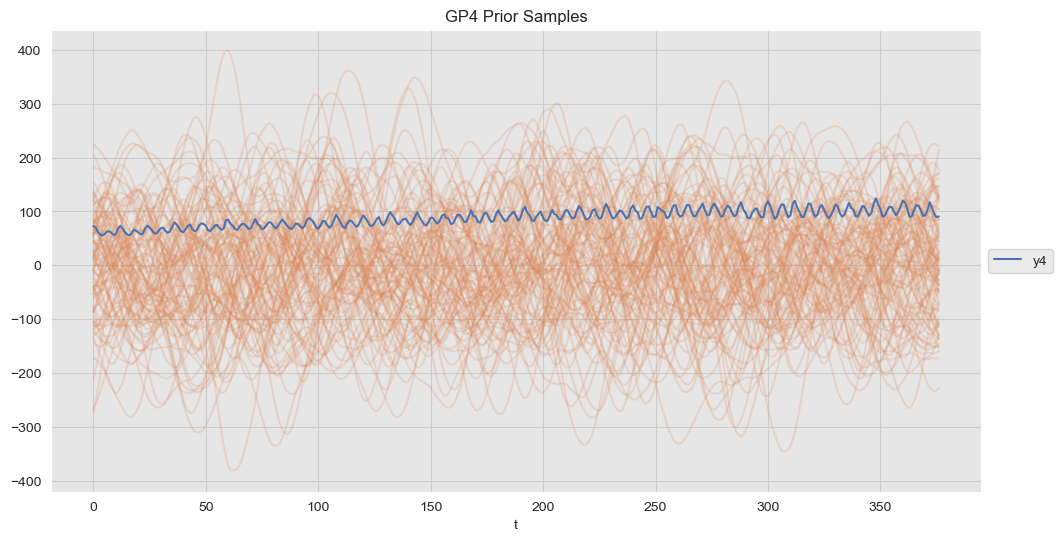

In [53]:
gp4_prior_samples = gp4.sample_y(X=X_train, n_samples=100)

fig, ax = plt.subplots()
for i in range(100):
    sns.lineplot(x=X_train[...,0], y = gp4_prior_samples[:, i], color=sns_c[1], alpha=0.2, ax=ax)
sns.lineplot(x=X_train[...,0], y=y_train[..., 0], color=sns_c[0], label='y4', ax=ax) 
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='GP4 Prior Samples', xlabel='t')

In [54]:
gp4.fit(X_train, y_train)

GaussianProcessRegressor(alpha=0.0,
                         kernel=WhiteKernel(noise_level=0.09) + 1.41**2 * ExpSineSquared(length_scale=1, periodicity=12) + 100**2 * RBF(length_scale=10) + 1**2 * ExpSineSquared(length_scale=1, periodicity=12),
                         n_restarts_optimizer=10, normalize_y=True)

In [55]:
k = 5*12 # 5 more cycles
t = n + np.arange(1,k)
future_df = pd.DataFrame({'Date': None, 'Production': None, 't': t})


In [56]:
new_df = pd.concat([gp_data, future_df], ignore_index=True)

In [57]:
gp_test = new_df['t'].to_numpy().reshape((new_df['t'].shape[0],1))

In [58]:
y_pred, y_std = gp4.predict(gp_test, return_std=True)

new_df['forecast'] = y_pred
new_df['std'] = y_std
new_df['forecast_lwr'] = new_df['forecast'] - 2*new_df['std']
new_df['forecast_upr'] = new_df['forecast'] + 2*new_df['std']

[Text(0.5, 1.0, 'Kaggle Real Data'),
 Text(0.5, 0, 'Month Number'),
 Text(0, 0.5, '')]

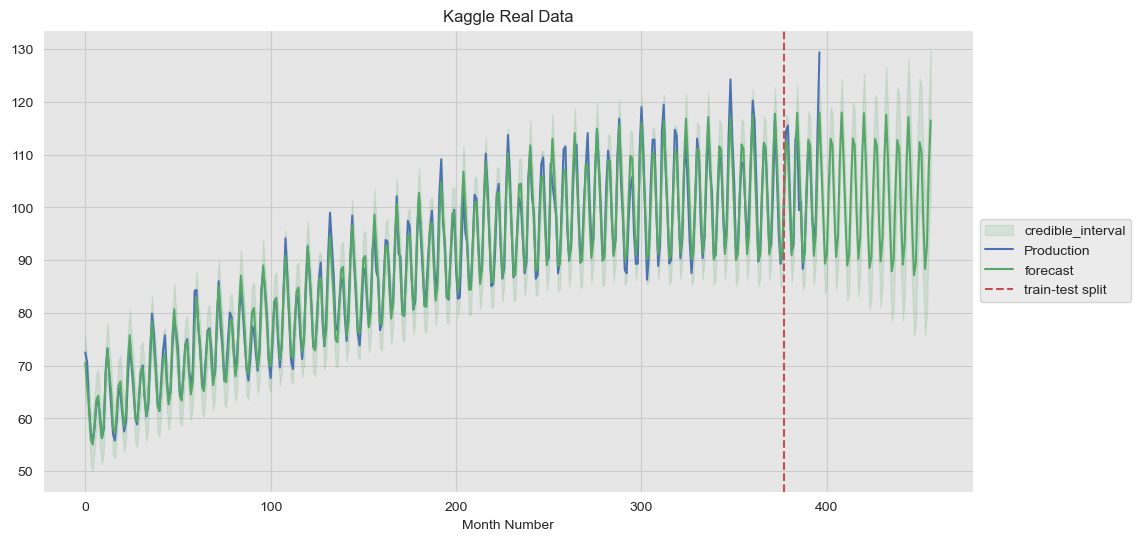

In [59]:
fig, ax = plt.subplots()

ax.fill_between(
    x=new_df['t'], 
    y1=new_df['forecast_lwr'], 
    y2=new_df['forecast_upr'], 
    color=sns_c[2], 
    alpha=0.15, 
    label='credible_interval'
)

sns.lineplot(x='t', y='Production', data=new_df, color=sns_c[0], label = 'Production', ax=ax)
sns.lineplot(x='t', y='forecast', data=new_df, color=sns_c[2], label='forecast', ax=ax)

ax.axvline(n_train, color=sns_c[3], linestyle='--', label='train-test split')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Kaggle Real Data', xlabel='Month Number', ylabel='')

In [60]:
from sklearn.metrics import mean_absolute_error
# print(f'R2 Score Train = {gp3.score(X=X_train, y=y_train): 0.3f}')
print(f'GP R2 Score Test = {gp4.score(X=X_test, y=y_test): 0.3f}')
print(f'SARIMAX R2 Score Test = {sarimax_R2_score: 0.3f}')

# print(f'MAE Train = {mean_absolute_error(y_true=y_train, y_pred=gp3.predict(X_train)): 0.3f}')
print(f'GP MAE Test = {mean_absolute_error(y_true=y_test, y_pred=gp4.predict(X_test)): 0.3f}')
print(f'SARIMAX MAE Test = {sarimax_MAE: 0.3f}')

GP R2 Score Test =  0.843
SARIMAX R2 Score Test =  0.856
GP MAE Test =  3.025
SARIMAX MAE Test =  2.881


c:\Users\Abhinav\anaconda3\envs\timeSeries\Lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 1.0, 'Sarimax Model - Errors'),
 Text(0.5, 0, 'error'),
 Text(0, 0.5, '')]

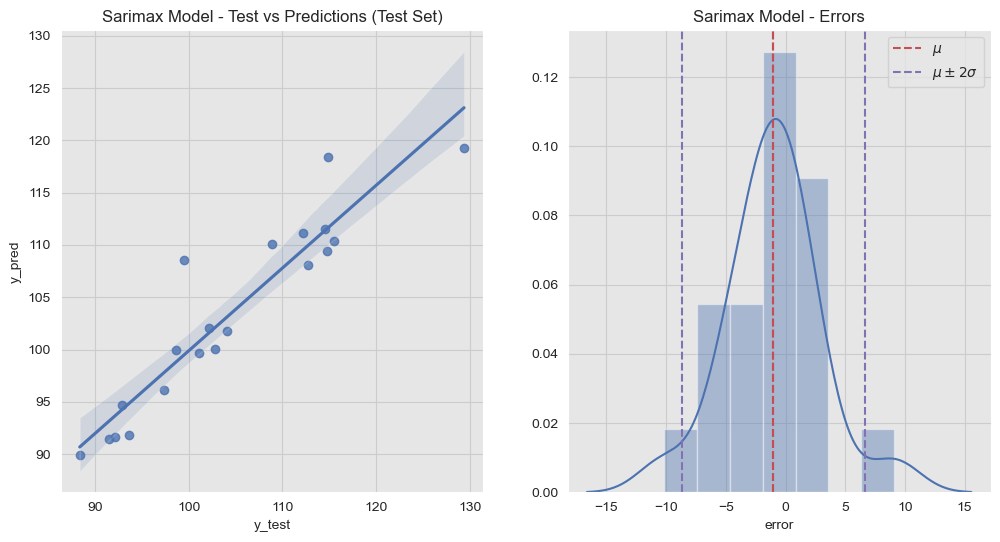

In [61]:
errors = sarimax_pred - sarimax_test
errors = errors.flatten()
errors_mean = errors.mean()
errors_std = errors.std()

fig, ax = plt.subplots(1, 2, figsize=(12, 6)) 
sns.regplot(x=sarimax_test.flatten(), y=sarimax_pred.flatten(), ax=ax[0])
sns.distplot(a=errors, ax=ax[1])
ax[1].axvline(x=errors_mean, color=sns_c[3], linestyle='--', label=f'$\mu$')
ax[1].axvline(x=errors_mean + 2*errors_std, color=sns_c[4], linestyle='--', label=f'$\mu \pm 2\sigma$')
ax[1].axvline(x=errors_mean - 2*errors_std, color=sns_c[4], linestyle='--')
ax[1].axvline(x=errors_mean, color=sns_c[3], linestyle='--')
ax[1].legend()
ax[0].set(title='Sarimax Model - Test vs Predictions (Test Set)', xlabel='y_test', ylabel='y_pred')
ax[1].set(title='Sarimax Model - Errors', xlabel='error', ylabel=None)

c:\Users\Abhinav\anaconda3\envs\timeSeries\Lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 1.0, 'Model 3  - Errors'), Text(0.5, 0, 'error'), Text(0, 0.5, '')]

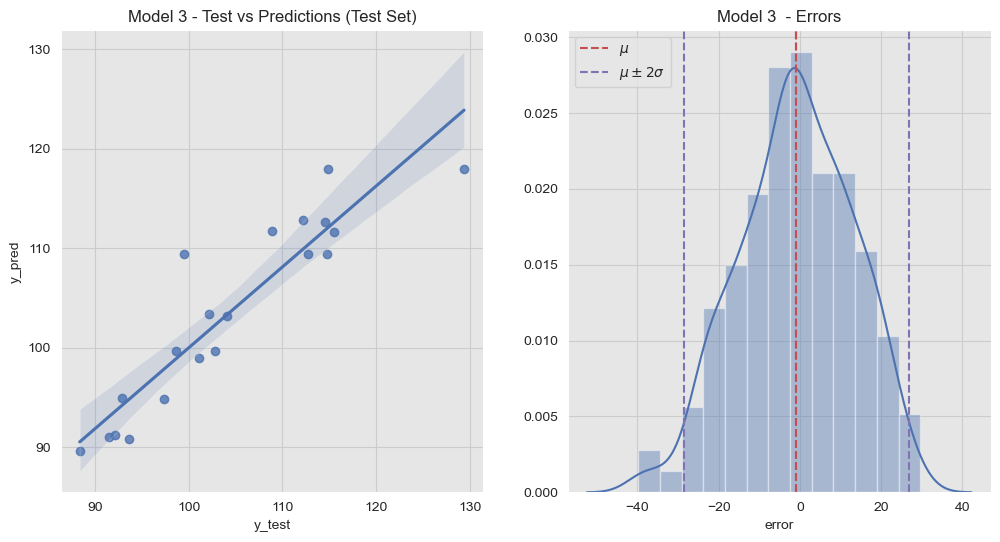

In [62]:
errors = gp4.predict(X_test) - y_test
errors = errors.flatten()
errors_mean = errors.mean()
errors_std = errors.std()

fig, ax = plt.subplots(1, 2, figsize=(12, 6)) 
sns.regplot(x=y_test.flatten(), y=gp4.predict(X_test).flatten(), ax=ax[0])
sns.distplot(a=errors, ax=ax[1])
ax[1].axvline(x=errors_mean, color=sns_c[3], linestyle='--', label=f'$\mu$')
ax[1].axvline(x=errors_mean + 2*errors_std, color=sns_c[4], linestyle='--', label=f'$\mu \pm 2\sigma$')
ax[1].axvline(x=errors_mean - 2*errors_std, color=sns_c[4], linestyle='--')
ax[1].axvline(x=errors_mean, color=sns_c[3], linestyle='--')
ax[1].legend()
ax[0].set(title='Model 3 - Test vs Predictions (Test Set)', xlabel='y_test', ylabel='y_pred')
ax[1].set(title='Model 3  - Errors', xlabel='error', ylabel=None)